In [2]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from models.gru import GRU
from losses.correlation_loss import CorrelationLoss
from losses.hybrid_loss import HybridLoss
from models.attention_gru import AttentionGRU

In [3]:
train_path = "/pool/btcavax/binance-usdtfutures/trades/btc/2024-01-29.csv"
test_path = "/pool/btcavax/binance-usdtfutures/trades/btc/2024-01-30.csv"

train = pd.read_csv(train_path, sep="|")
test = pd.read_csv(test_path, sep="|")

In [4]:
train.head()

,symbol,side,time,price,volume
0,BTCUSDT,0,1706486400134000,42021.2,924.4664
1,BTCUSDT,1,1706486400169000,42021.3,336.1704
2,BTCUSDT,0,1706486400192000,42021.2,420.2120
3,BTCUSDT,1,1706486400229000,42021.3,4160.1087
4,BTCUSDT,1,1706486400235000,42021.3,126.0639


In [36]:
# log returns column, look back 5 rows
def data_processing(orderbook_df, time_bucket="1ms"):
    orderbook_df['datetime'] = pd.to_datetime(orderbook_df['time'], unit='ns')
    orderbook_df['bucket'] = orderbook_df['datetime'].dt.floor(time_bucket)

    results = []

    # Group by the 5-minute buckets
    for bucket, group in orderbook_df.groupby('bucket'):
        # Ensure there are both bid and ask rows
        bids = group[group['side'] == 0]
        asks = group[group['side'] == 1]

        if not bids.empty and not asks.empty:
            # # Mid price from the first bid-ask pair
            # first_bid = bids.iloc[0]['price']
            # first_ask = asks.iloc[0]['price']
            # mid_price_first = (first_bid + first_ask) / 2

            # first_bid_volume = bids.iloc[0]['volume']
            # first_ask_volume = asks.iloc[0]['volume']
            # first_trade_volume = min(first_bid_volume, first_ask_volume)

            # # Mid price from highest bid and lowest ask in the bucket
            # last_bid = bids.iloc[-1]['price']
            # last_ask = asks.iloc[-1]['price']
            # mid_price_last = (last_bid + last_ask) / 2

            # last_bid_volume = bids.iloc[-1]['volume']
            # last_ask_volume = asks.iloc[-1]['volume']
            # last_trade_volume = min(last_bid_volume, last_ask_volume)

            max_bid = bids["price"].max()
            min_ask = asks["price"].min()

            mid_price = (max_bid + min_ask) / 2

            results.append({
                'bucket': bucket,
                'time': bucket.value // 10**6,
                'mid_price': mid_price,
            })

    final_df = pd.DataFrame(results)
    final_df["shift_mid_price"] = final_df["mid_price"].shift(-1)
    final_df.dropna()
    final_df["return"] = final_df["shift_mid_price"] / final_df["mid_price"]
    final_df["log_return"] = np.log(final_df["return"])

    # final_df['time'] = final_df['bucket'].astype('int64') // 10**6

    # Return the results as a DataFrame
    return final_df.dropna()

In [37]:
processed_train = data_processing(train, "10ms")
processed_train.shape

(8638, 6)

In [38]:
processed_train.head(10)

,bucket,time,mid_price,shift_mid_price,return,log_return
0,1970-01-20 18:01:26.400,1706486400,42040.65,42026.45,0.999662,-0.000338
1,1970-01-20 18:01:26.410,1706486410,42026.45,42025.85,0.999986,-0.000014
2,1970-01-20 18:01:26.420,1706486420,42025.85,42010.30,0.999630,-0.000370
3,1970-01-20 18:01:26.430,1706486430,42010.30,41984.55,0.999387,-0.000613
4,1970-01-20 18:01:26.440,1706486440,41984.55,41973.20,0.999730,-0.000270
5,1970-01-20 18:01:26.450,1706486450,41973.20,41983.95,1.000256,0.000256
6,1970-01-20 18:01:26.460,1706486460,41983.95,41972.40,0.999725,-0.000275
7,1970-01-20 18:01:26.470,1706486470,41972.40,41966.40,0.999857,-0.000143
8,1970-01-20 18:01:26.480,1706486480,41966.40,41966.00,0.999990,-0.000010
9,1970-01-20 18:01:26.490,1706486490,41966.00,41940.25,0.999386,-0.000614


In [39]:
# TODO: This is dated, update to reflect better data processing
train = data_processing(train)
test = data_processing(test)

feature_columns = ["volume", "side", "log_returns_back1", "log_returns_back2", "log_returns_back3", "log_returns_back4", "log_returns_back5"]
target_columns = ["log_returns"]

train_features = train[feature_columns]
train_targets = train[target_columns]

test_features = test[feature_columns]
test_targets = test[target_columns]

train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_targets = torch.tensor(train_targets.values, dtype=torch.float32)
test_features = torch.tensor(test_features.values, dtype=torch.float32)
test_targets = torch.tensor(test_targets.values, dtype=torch.float32)

KeyboardInterrupt: 

In [14]:
# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

In [15]:
seq_length = 5
X_train, y_train = create_sequences(train_features, train_targets, seq_length)
X_test, y_test = create_sequences(test_features, test_targets, seq_length)

device = torch.device("cpu")
input_size = 7
context_size = input_size  # assuming context comes from the same input features
hidden_size = 16
output_size = 2  # meantemp and humidity

In [16]:
# Initialize the AttentionGRU model & define loss and optimizer
attention_gru_model = AttentionGRU(input_size, hidden_size, context_size, output_size, device).to(device)
criterion = CorrelationLoss()  # Adjust weight if necessary
optimizer = optim.Adam(attention_gru_model.parameters(), lr=0.001)

# Training
num_epochs = 100
batch_size = 16

for epoch in range(num_epochs):
    attention_gru_model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size].to(device)  # (batch_size, seq_length, input_size)
        y_batch = y_train[i:i + batch_size].to(device)  # (batch_size, output_size)
        
        context = X_batch  # (batch_size, seq_length, input_size)
        
        optimizer.zero_grad()
        outputs, _ = attention_gru_model(X_batch, context)  # outputs: (batch_size, seq_length, output_size)
        
        # NOTE We might need to adjust outputs and y_batch dimensions since outputs are per timestep, but y_batch is per sequence
        outputs = outputs[:, -1, :]  # (batch_size, output_size)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attention_gru_model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(X_train)}")

Epoch 1/100, Loss: 0.06313810606098655
Epoch 2/100, Loss: 0.06310033894064439
Epoch 3/100, Loss: 0.06338423340763878
Epoch 4/100, Loss: 0.06321975789477478
Epoch 5/100, Loss: 0.06322935118747117
Epoch 6/100, Loss: 0.06333849136553817
Epoch 7/100, Loss: 0.0631770525745411
Epoch 8/100, Loss: 0.06321377197102686
Epoch 9/100, Loss: 0.06310648912161439
Epoch 10/100, Loss: 0.06310457835844414
Epoch 11/100, Loss: 0.0632814736222502
Epoch 12/100, Loss: 0.06319378207077334
Epoch 13/100, Loss: 0.06341035228278769
Epoch 14/100, Loss: 0.06316617086305092
Epoch 15/100, Loss: 0.06312366741985533
Epoch 16/100, Loss: 0.06316554803944113
Epoch 17/100, Loss: 0.0632918330293205
Epoch 18/100, Loss: 0.06320092480386322
Epoch 19/100, Loss: 0.06303398740950542
Epoch 20/100, Loss: 0.06331168185526402
Epoch 21/100, Loss: 0.06294817684882849
Epoch 22/100, Loss: 0.06317214037305746
Epoch 23/100, Loss: 0.06289269876240486
Epoch 24/100, Loss: 0.06321992706413844
Epoch 25/100, Loss: 0.06281736573981281
Epoch 26/100

Test Loss: 0.9971985816955566


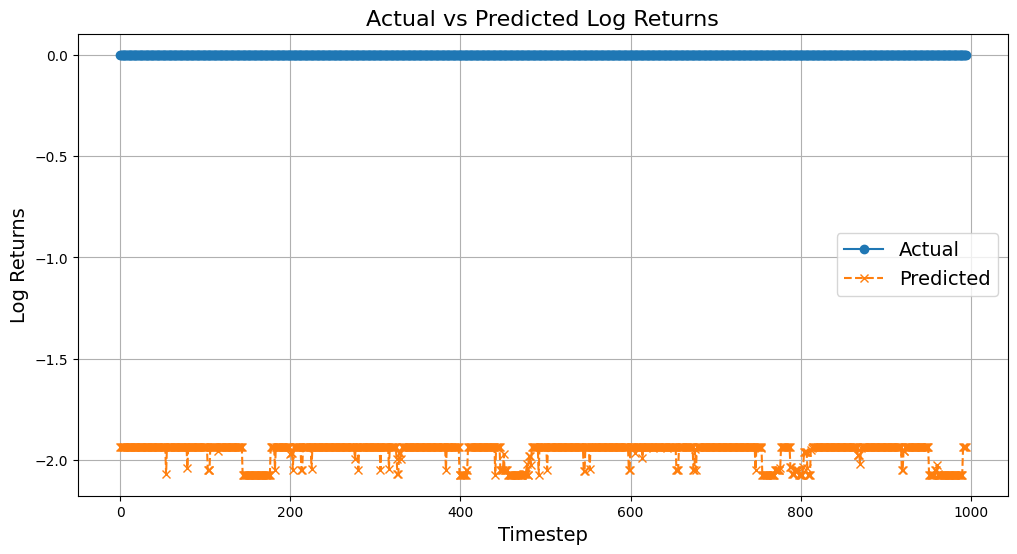

In [17]:
# Testing
attention_gru_model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    context_test = X_test
    predictions, attention_weights = attention_gru_model(X_test, context_test)
    predictions = predictions[:, -1, :]
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item()}")

# Plot results
def plot_results(y_true, y_pred, feature_name, feature_index):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='-', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

plot_results(y_test, predictions, "Log Returns", 0)
